# Age and Gender classification
# Cleaning the Merged Dataset

### Environment setup

In [1]:
import os 
import sys
sys.path
sys.path.append('..')
import pandas as pd
from utils import process_image_with_fan

from utils import process_images_with_landmarks, gather_landmark_data
from utils import plot_multiple_normalized_landmarks
from utils import capture_faces_fan, capture_faces_mtcnn
from utils import get_df_filenames
from utils import gather_all_outliers
from utils import find_and_plot_outliers, display_images_for_outliers
from utils import gather_all_outliers_in_batches
from utils import plot_multiple_normalized_landmarks_with_outliers

import time
import warnings
warnings.filterwarnings("ignore", module="face_alignment")

### Loading the data

In [2]:
path_data = '../data/merged'

In [3]:
df_labels = pd.read_csv('../data/merged/df_labels_clean.csv')

### Extraction and Visualization of the Key Landmarks

In this part of the project, we are using the Face Alignment Network (FAN) model to capture and visualize key facial landmarks in a normalized format. The landmarks include critical facial features like the left and right eyes, the nose, and the left and right corners of the mouth. By normalizing these coordinates, we can analyze the relative positions of these facial features across the entire dataset, ensuring alignment consistency.

In [4]:
landmarks_df = gather_landmark_data(df_labels, path_data, num_images=None)

Processing images: 100%|█████████████████████████████████████████████████████| 116886/116886 [1:16:40<00:00, 25.41it/s]


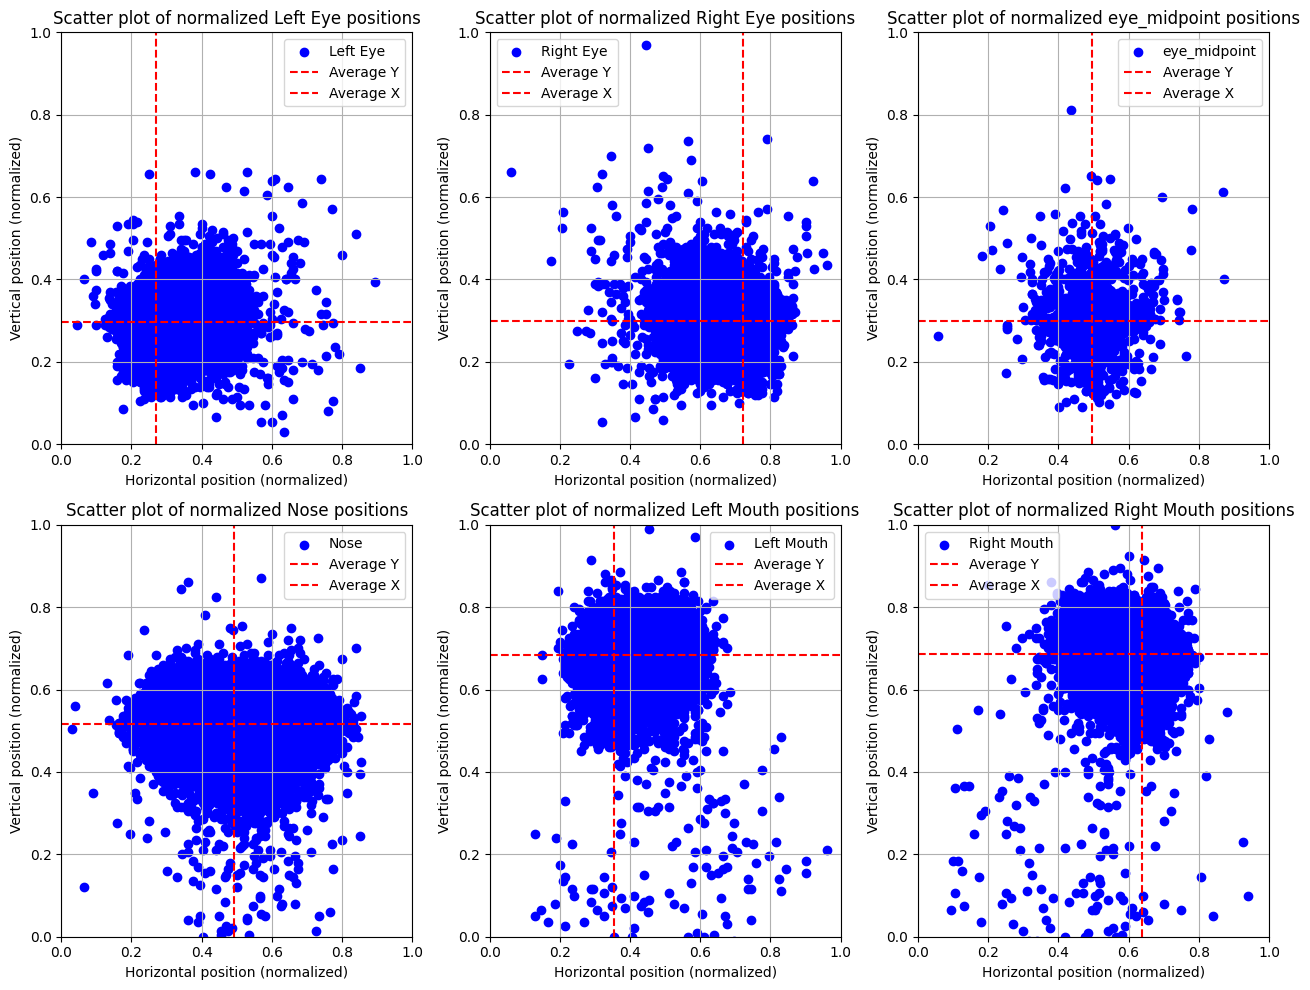

In [5]:
columns = ['normalized_left_eye', 'normalized_right_eye', 'normalized_eye_midpoint', 'normalized_nose', 
           'normalized_left_mouth', 'normalized_right_mouth']
labels = ['Left Eye', 'Right Eye', 'eye_midpoint', 'Nose', 'Left Mouth', 'Right Mouth']
landmarks_df.dropna(inplace=True)
plot_multiple_normalized_landmarks(landmarks_df, columns, labels)

### Catching Outliers using DBSCAN

Next, we are identifying and visualizing outliers in the facial landmark data using the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm. By detecting outliers, we aim to identify any anomalies in the facial landmark positions that could impact model performance or alignment accuracy.

In [6]:
batch_size = 20000

all_outliers = gather_all_outliers_in_batches(landmarks_df, columns, batch_size=batch_size, eps=0.03, min_samples=5)

We have set a batch size of 20,000 and applied DBSCAN with specific parameters (eps=0.03, min_samples=5). This clustering technique helps us isolate landmark positions that deviate significantly from the main clusters, marking them as outliers. The landmarks identified as outliers are then separated from the main dataset for further inspection.

In [7]:
landmarks_df_clean = landmarks_df[~landmarks_df['filename'].isin(all_outliers['filename'])]

### Visualizing the Outliers separated usig DBSCAN

The plots show scatter distributions of normalized positions for each key landmark: left eye, right eye, eye midpoint, nose, left mouth, and right mouth. Each plot includes:

* Blue points representing inliers (standard data points) for each landmark.
* Red points representing outliers identified by DBSCAN.
* The red dashed lines represent the average x and y positions for each landmark, providing a reference point for typical landmark positioning.

Through these visualizations, we can see how some facial landmarks deviate from the central tendency. Identifying these outliers enables us to refine the dataset.

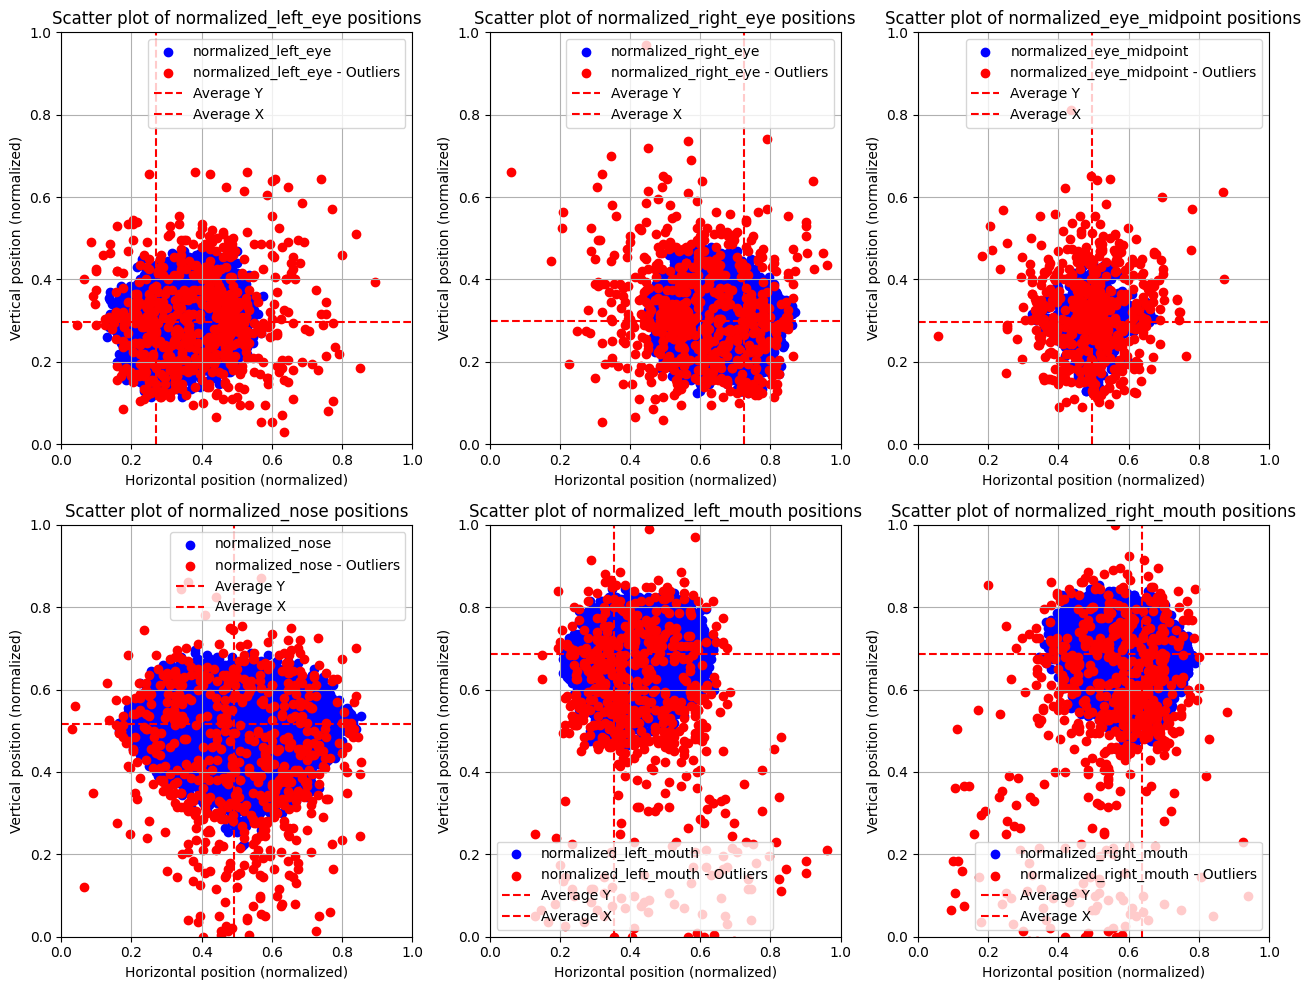

In [8]:
plot_multiple_normalized_landmarks_with_outliers(landmarks_df_clean, all_outliers, columns)

In some plots, we observe that certain red points (outliers) overlap with the denser areas of blue points, indicating that these red points fall within the expected range of landmark positions. This overlap is likely because the DBSCAN algorithm flagged other associated landmarks from the same image as outliers, resulting in all landmarks for that image being marked as outliers, even if some of their coordinates appear typical.

In [9]:
landmarks_df_clean.to_csv('../data/merged/landmarks_df_clean.csv', index=False)

### Catching outliers of Eye Distance Values

In this section, we focus on detecting outliers in the eye distance values. The eye distance, calculated as the distance between the left and right eye landmarks, serves as an indicator of face alignment and position within the image. Identifying outliers in eye distance helps us detect cases where the face is at an extreme angle or where facial proportions differ significantly.

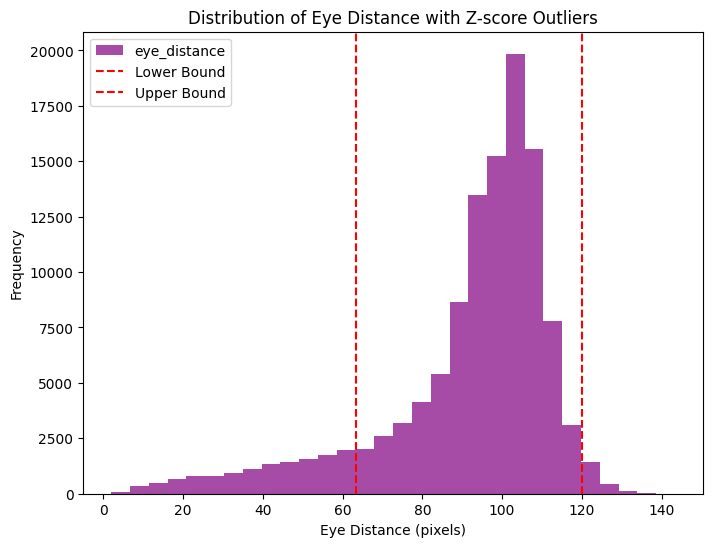

In [10]:
eye_d_outliers_df = find_and_plot_outliers(landmarks_df_clean, column='eye_distance', threshold=1.3)

We applied Z-score analysis to detect outliers based on eye distance, setting a threshold of 1.3. This method flags values that deviate significantly from the mean, marking those that fall outside the specified range as outliers. The histogram shows the distribution of eye distances, with the red dashed lines indicating the upper and lower Z-score boundaries for outlier detection.

### Observations of Outliers

Most of the outliers identified are faces that are either positioned at an angle (profile views or partial angles) or belong to young children, whose facial proportions naturally differ from adults. Faces at extreme angles result in lower eye distance values due to the side-view orientation, while children's faces tend to have smaller eye distances because of their distinct facial proportions.

In [11]:
eye_d_outliers_df.shape

(15277, 2)

In [12]:
eye_d_outliers_sample = eye_d_outliers_df.sample(n=100)

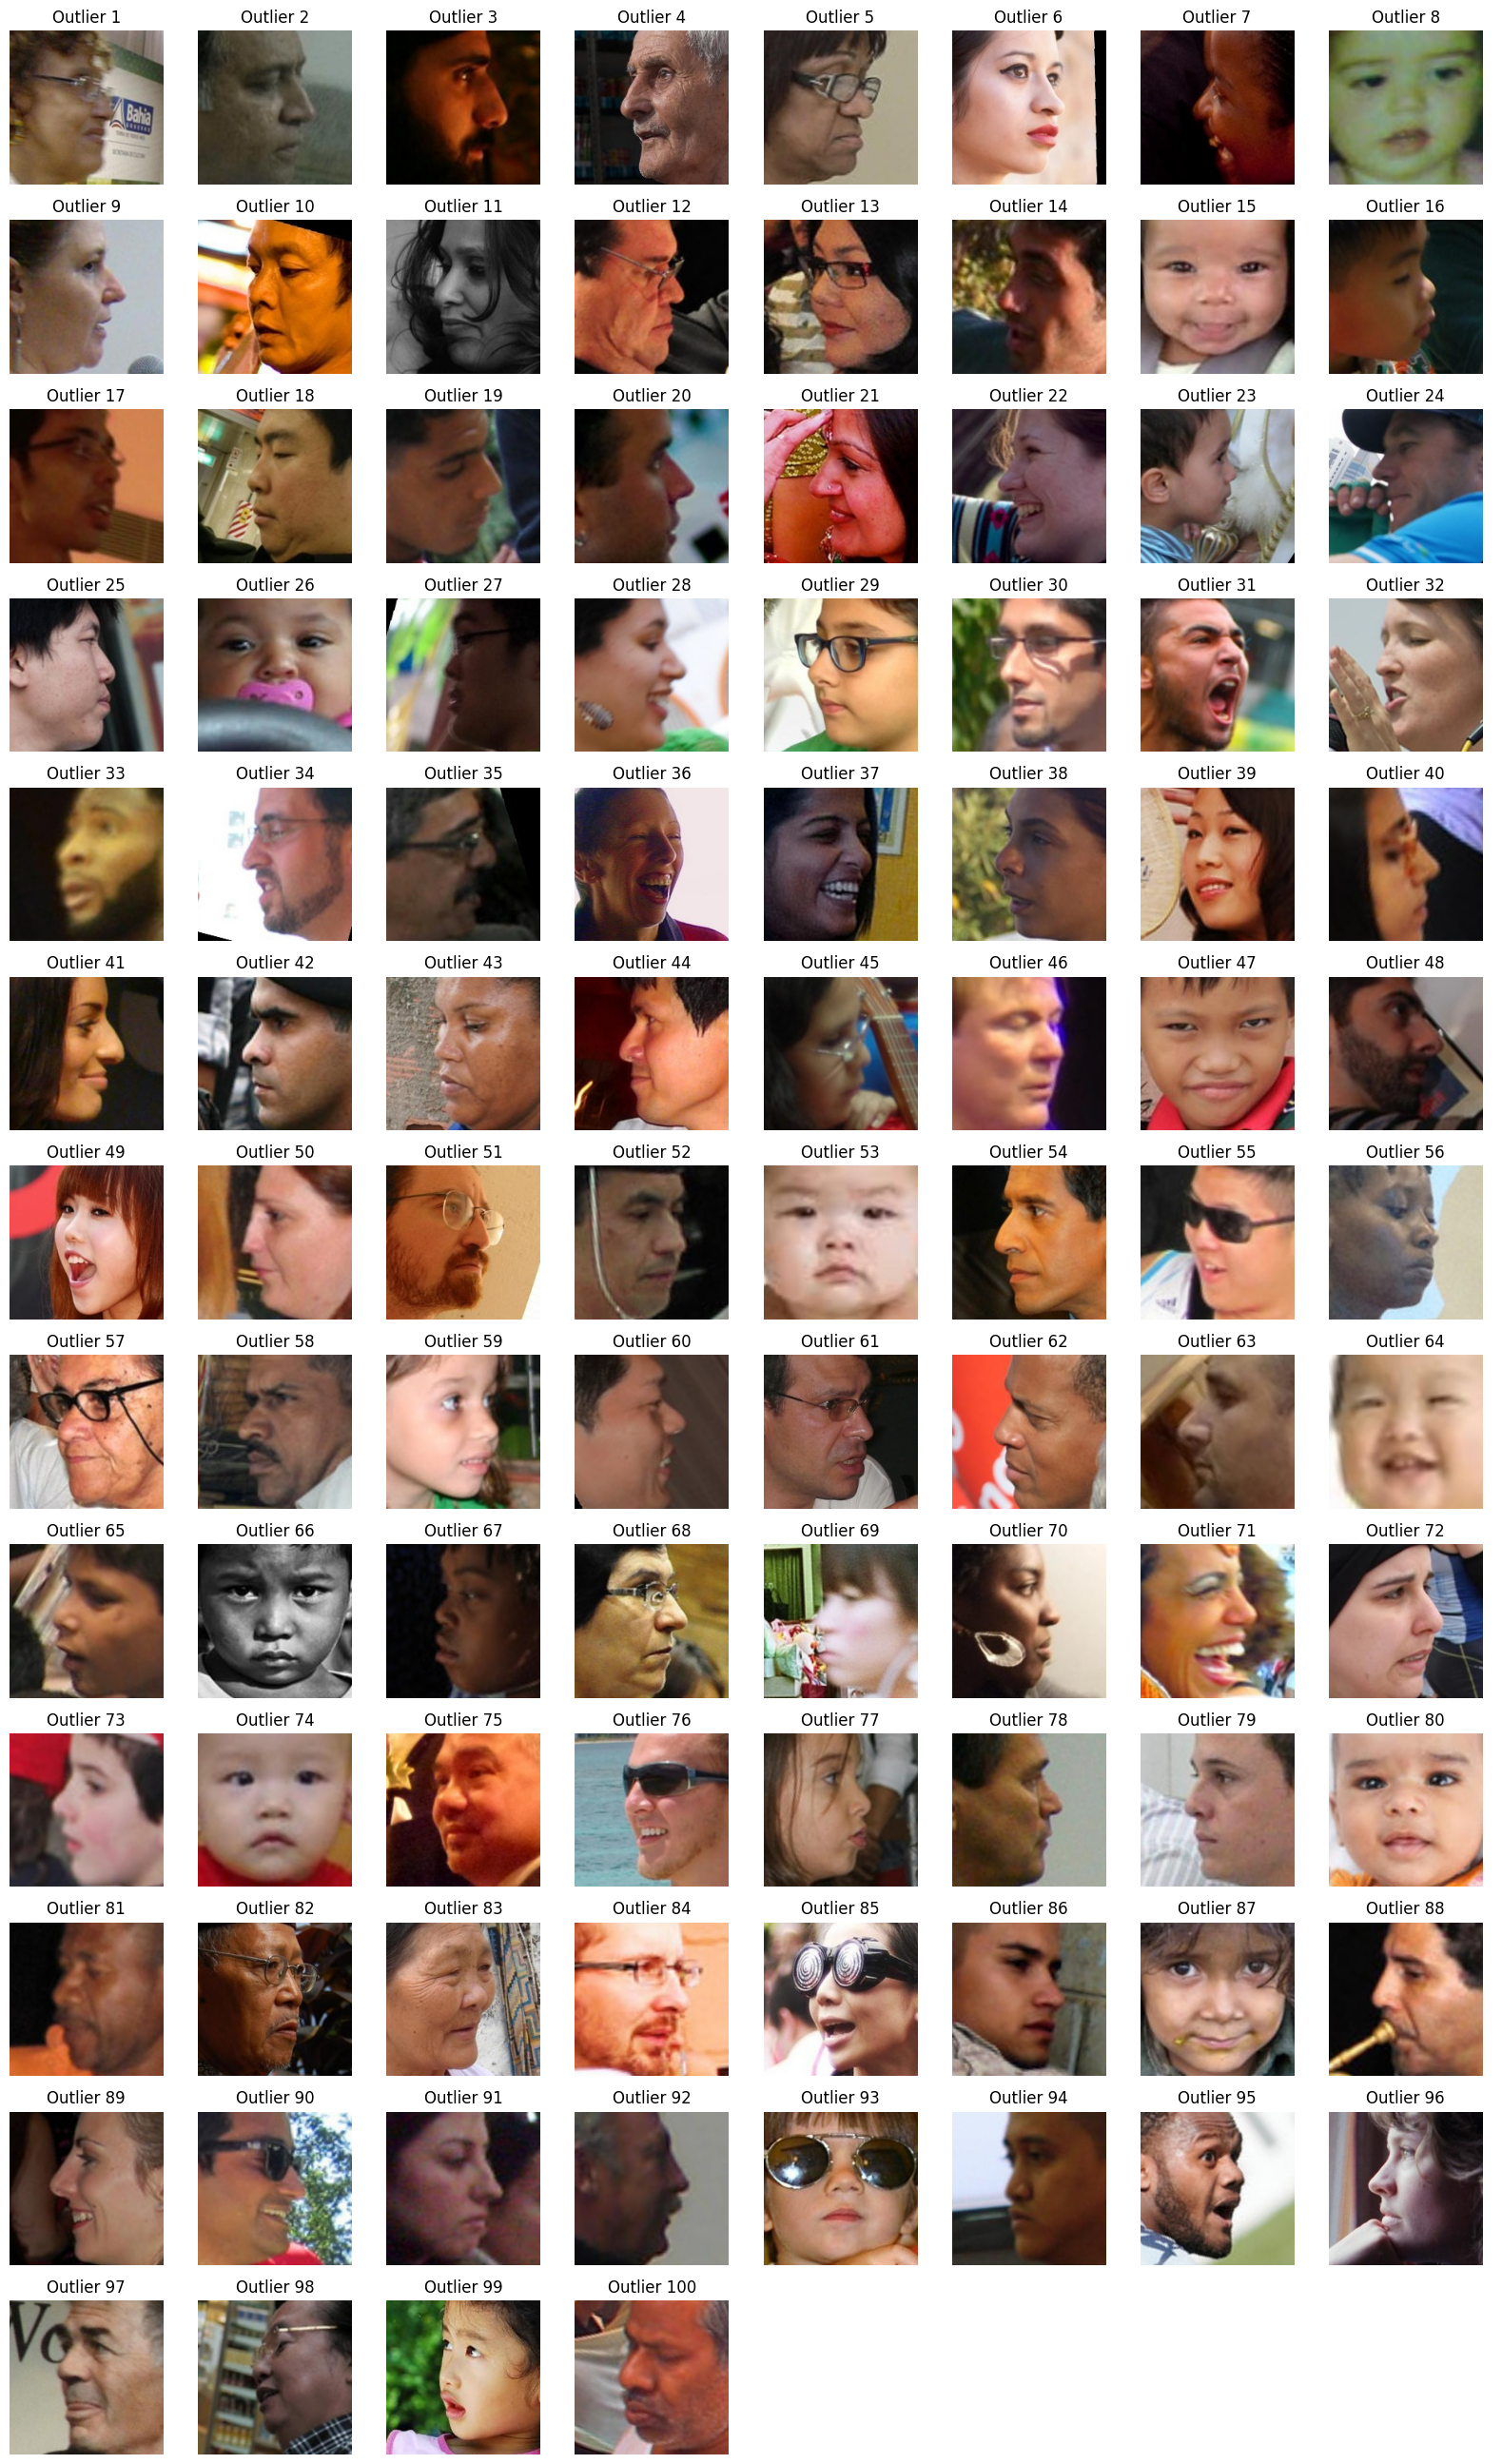

In [13]:
display_images_for_outliers(eye_d_outliers_sample, folder_path=path_data, images_per_row=8)

### Extracting Information for further uses

In [14]:
outliers_filenames = pd.concat([all_outliers['filename'], eye_d_outliers_df['filename']])
df_labels_cleaned = df_labels[~df_labels['filename'].isin(outliers_filenames)]
df_labels_cleaned.reset_index(drop=True, inplace=True)

df_labels_cleaned.sample(5)

filename  gender  race  age_group  face_found_mtcnn  \
36557  face29305_0_2_5.jpg       0     2          5                 1   
35855  face28532_0_0_6.jpg       0     0          6                 1   
47328   face4110_0_0_3.jpg       0     0          3                 1   
60853   face5592_1_3_3.jpg       1     3          3                 1   
72194  face68357_0_0_7.jpg       0     0          7                 1   

       face_found  models_recognized  
36557           1                  1  
35855           1                  1  
47328           1                  1  
60853           1                  1  
72194           1                  1

In [67]:
df_labels_cleaned = df_labels_cleaned.drop(columns=['face_found_mtcnn', 'face_found', 'models_recognized'])

In [69]:
df_labels_cleaned.to_csv('../data/merged/df_labels_cleaned.csv', index=False)